In [1]:
%run 0_result_analysis_functions.ipynb

In [2]:
# Import catalog with SimstackWrapper

# 2-sf/qt
combined_pickle_filename = "uVista_DR2_SFQT_nuvrj_0p01_0p5_1_1p5_2_2p5_3_3p5_4_5p0_X_4_foregnd_atonce_"
prefix='SF_QT__A gt_n35p5_'

combined_pickle_path = os.environ['PICKLESPATH']+'/'+os.path.join("simstack","stacked_flux_densities", combined_pickle_filename)
underscore_suffix = "" # "__"
path_ini_file = os.path.join(combined_pickle_path+underscore_suffix, "uvista.ini")
path_pickle_file = os.path.join(combined_pickle_path+underscore_suffix, combined_pickle_filename+".pkl")
if os.path.isfile(path_ini_file):
    simstack_catalog_object = SimstackWrapper(path_ini_file, read_maps=False, read_catalog=True, keep_catalog=True, stack_automatically=False, save_automatically=False)
else:
    print(path_ini_file+' not found')

In [3]:
simstack_maps_object = SimstackWrapper(path_ini_file, save_automatically=False, read_maps=True, read_catalog=False)

In [4]:
# Import saved stacking results
simstack_object = SimstackToolbox.import_saved_pickles(path_pickle_file)

In [5]:
# Pass saved results into SimstackResults
simstack_object = SimstackResults(simstack_object)

In [6]:
# Pass saved results into SimstackPlots
simstack_object = SimstackPlots(simstack_object)

In [7]:
simstack_object.config_dict['catalog']['classification'].keys()

dict_keys(['redshift', 'stellar_mass', 'split_params'])

In [8]:
fluxes_dict = parse_fluxes(simstack_object)

In [9]:
np.shape(fluxes_dict['flux'])

(7, 9, 4, 2)

In [10]:
# SLOW!
sed_dict = get_fast_sed_dict(simstack_object, fluxes_dict, simstack_catalog_object)

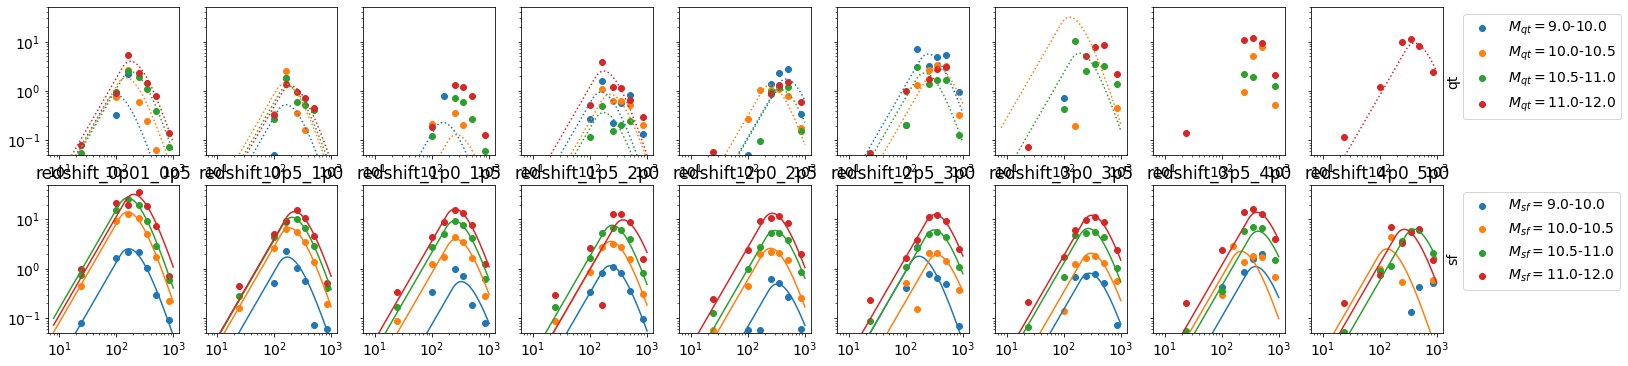

In [11]:
plot_pops(simstack_object,sed_dict=sed_dict)

# Fit model to stacked Fluxes

In [12]:
As_sf = np.array([sed_dict['sed_params'][i]['A'].value for i in sed_dict['sed_params'] if 'params_0' not in i])
Ts_sf = np.array([(1+sed_dict['redshift'][i])*sed_dict['sed_params'][i]['T_observed'].value for i in sed_dict['sed_params'] if 'params_0' not in i])

Ms_sf = np.array([sed_dict['stellar_mass'][i] for i in sed_dict['stellar_mass'] if 'params_0' not in i])
Zs_sf = np.array([sed_dict['redshift'][i] for i in sed_dict['redshift'] if 'params_0' not in i])

In [13]:
As_qt = np.array([sed_dict['sed_params'][i]['A'].value for i in sed_dict['sed_params'] if 'params_1' not in i])
Ts_qt = np.array([(1+sed_dict['redshift'][i])*sed_dict['sed_params'][i]['T_observed'].value for i in sed_dict['sed_params'] if 'params_1' not in i])

Ms_qt = np.array([sed_dict['stellar_mass'][i] for i in sed_dict['stellar_mass'] if 'params_1' not in i])
Zs_qt = np.array([sed_dict['redshift'][i] for i in sed_dict['redshift'] if 'params_1' not in i])

In [14]:
idx_keep_sf = (Zs_sf > 0.1) & (As_sf > -35.5) & (Ts_sf < 65)
cube_sf = np.array([Zs_sf[idx_keep_sf],Ms_sf[idx_keep_sf]])
idx_keep_qt = (Zs_qt > 0.1) & (As_qt > -35.5) & (Ts_qt < 65)
cube_qt = np.array([Zs_qt[idx_keep_qt],Ms_qt[idx_keep_qt]])

In [15]:
# Define Fit Parameters
fit_params_Adust = Parameters()
fit_params_Adust.add('offset', value=1e-3 * np.random.randn())
fit_params_Tdust = Parameters()
fit_params_Tdust.add('offset', value=1e-3 * np.random.randn())

catalog_keys = []
for key, val in simstack_object.config_dict['catalog']['classification'].items():
    if 'redshift' in key:
        value = 1.4
    else:
        value=1e-3 * np.random.randn()
        
    if 'split_params' not in key:
        fit_params_Adust.add('slope_'+key, value=value)
        fit_params_Tdust.add('slope_'+key, value=value)
        catalog_keys.append(val['id'])
    
cov_Adust_sf = minimize(slope_A_Tdust, fit_params_Adust,
                     args=(cube_sf,),
                     kws={'y': As_sf[idx_keep_sf]},
                     nan_policy='propagate')
cov_Tdust_sf = minimize(slope_A_Tdust, fit_params_Tdust,
                     args=(cube_sf,),
                     kws={'y': Ts_sf[idx_keep_sf]},
                     nan_policy='propagate')

In [16]:
# Define Fit Parameters
fit_params_Adust = Parameters()
fit_params_Adust.add('offset', value=1e-3 * np.random.randn())
fit_params_Tdust = Parameters()
fit_params_Tdust.add('offset', value=1e-3 * np.random.randn())

catalog_keys = []
for key, val in simstack_object.config_dict['catalog']['classification'].items():
    if 'redshift' in key:
        value = 1.4
    else:
        value=1e-3 * np.random.randn()
        
    if 'split_params' not in key:
        fit_params_Adust.add('slope_'+key, value=value)
        fit_params_Tdust.add('slope_'+key, value=value)
        catalog_keys.append(val['id'])
    
cov_Adust_qt = minimize(slope_A_Tdust, fit_params_Adust,
                     args=(cube_qt,),
                     kws={'y': As_qt[idx_keep_qt]},
                     nan_policy='propagate')
cov_Tdust_qt = minimize(slope_A_Tdust, fit_params_Tdust,
                     args=(cube_qt,),
                     kws={'y': Ts_qt[idx_keep_qt]},
                     nan_policy='propagate')

In [17]:
catalog_keys_sfg = catalog_keys.copy()
catalog_keys_sfg.append('sfg')

In [18]:
idx_sfgs = simstack_catalog_object.catalog_dict['tables']['full_table']['sfg'] == 1
idx_qts = simstack_catalog_object.catalog_dict['tables']['full_table']['sfg'] == 0

In [19]:
model_cube_sf = simstack_catalog_object.catalog_dict['tables']['full_table'].loc[idx_sfgs][catalog_keys]

Z_model_sf = simstack_catalog_object.catalog_dict['tables']['full_table'].loc[idx_sfgs]['z_peak']
M_model_sf = simstack_catalog_object.catalog_dict['tables']['full_table'].loc[idx_sfgs]['LMASS']
ra_model_sf = simstack_catalog_object.catalog_dict['tables']['full_table'].loc[idx_sfgs]['ra']
dec_model_sf = simstack_catalog_object.catalog_dict['tables']['full_table'].loc[idx_sfgs]['dec']
uv_sfr_sf = simstack_catalog_object.catalog_dict['tables']['full_table'].loc[idx_sfgs]['SFR_UV']

In [20]:
model_cube_qt = simstack_catalog_object.catalog_dict['tables']['full_table'].loc[idx_qts][catalog_keys]
  
Z_model_qt = simstack_catalog_object.catalog_dict['tables']['full_table'].loc[idx_qts]['z_peak']
M_model_qt = simstack_catalog_object.catalog_dict['tables']['full_table'].loc[idx_qts]['LMASS']
ra_model_qt = simstack_catalog_object.catalog_dict['tables']['full_table'].loc[idx_qts]['ra']
dec_model_qt = simstack_catalog_object.catalog_dict['tables']['full_table'].loc[idx_qts]['dec']
uv_sfr_qt = simstack_catalog_object.catalog_dict['tables']['full_table'].loc[idx_qts]['SFR_UV']

In [21]:
model_cube = simstack_catalog_object.catalog_dict['tables']['full_table'][catalog_keys_sfg]

Z_model = simstack_catalog_object.catalog_dict['tables']['full_table']['z_peak']
M_model = simstack_catalog_object.catalog_dict['tables']['full_table']['z_peak']
ra_model = simstack_catalog_object.catalog_dict['tables']['full_table']['ra']
dec_model = simstack_catalog_object.catalog_dict['tables']['full_table']['dec']
uv_sfr = simstack_catalog_object.catalog_dict['tables']['full_table']['SFR_UV']

In [22]:
model_cube_sf = model_cube_sf.to_numpy().T
model_cube_qt = model_cube_qt.to_numpy().T
model_cube = model_cube.to_numpy().T

In [23]:
A_model_sf = model_A_Tdust(cov_Adust_sf.params, model_cube_sf)
T_model_sf = model_A_Tdust(cov_Tdust_sf.params, model_cube_sf)

In [24]:
A_model_qt = model_A_Tdust(cov_Adust_qt.params, model_cube_qt)
T_model_qt = model_A_Tdust(cov_Tdust_qt.params, model_cube_qt)

## Fit parameters directly to maps?

In [25]:
idx_sim_sf = (A_model_sf > -35.5) & (A_model_sf < -32) & (T_model_sf < 65) & (Z_model_sf > 0.1)
idx_sim_qt = (A_model_qt > -35.5) & (A_model_qt < -32) & (T_model_qt < 65) & (Z_model_qt > 0.1)

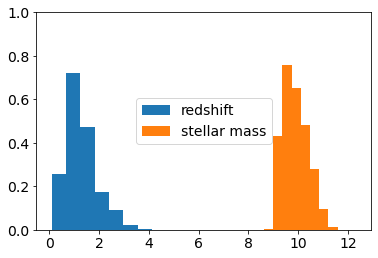

In [26]:
plt.hist(model_cube_sf[:,idx_sim_sf][0], density=True, label='redshift')
plt.hist(model_cube_sf[:,idx_sim_sf][1], density=True, label='stellar mass')
plt.ylim([0,1])
plt.legend(loc='center');

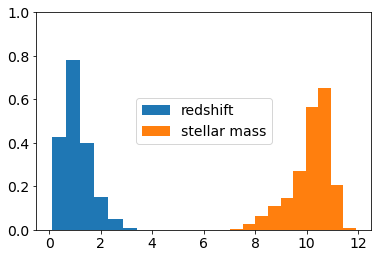

In [27]:
plt.hist(model_cube_qt[:,idx_sim_qt][0], density=True, label='redshift')
plt.hist(model_cube_qt[:,idx_sim_qt][1], density=True, label='stellar mass')
plt.ylim([0,1])
plt.legend(loc='center');

In [28]:
map_dict_sf = {}
for map_key in simstack_maps_object.maps_dict:
    map_object = simstack_maps_object.maps_dict[map_key].copy()
    x, y = get_x_y_from_ra_dec(map_object, ra_model_sf[idx_sim_sf], dec_model_sf[idx_sim_sf])
    map_object['map_coords'] = [x,y]
    map_dict_sf[map_key]=map_object

In [29]:
map_dict_qt = {}
for map_key in simstack_maps_object.maps_dict:
    map_object = simstack_maps_object.maps_dict[map_key].copy()
    x, y = get_x_y_from_ra_dec(map_object, ra_model_qt[idx_sim_qt], dec_model_qt[idx_sim_qt])
    map_object['map_coords'] = [x,y]
    map_dict_qt[map_key]=map_object

In [30]:
map_dict = {}
for map_key in simstack_maps_object.maps_dict:
    map_object = simstack_maps_object.maps_dict[map_key].copy()
    map_object['map_coords']={}
    x_sf, y_sf = get_x_y_from_ra_dec(map_object, ra_model_sf, dec_model_sf)
    map_object['map_coords']['sf'] = [x_sf,y_sf]
    x_qt, y_qt = get_x_y_from_ra_dec(map_object, ra_model_qt, dec_model_qt)
    map_object['map_coords']['qt'] = [x_qt,y_qt]
    map_dict[map_key]=map_object

In [31]:
def direct_convolved_fit_A_Tdust_one_pop(params, X, y):

    v = params.valuesdict()#.copy()
    A_model = v.pop('A_offset')
    T_model = v.pop('T_offset')
    Z_model = X[0]
    i=0
    for ival in v:
        #print(ival)
        if 'A_' in ival:
            A_model+= X[i] * v[ival]
        else:
            T_model+= X[i] * v[ival]
            i+=1
    #pdb.set_trace()
    out_model = []
    for map_name in y:
        map_lambda = y[map_name]['wavelength']
        map_nu = c * 1.e6/map_lambda
        map_coords = y[map_name]['map_coords']
        hd = y[map_name]['header']
        map_sky = y[map_name]['map'] - np.mean(y[map_name]['map'])

        map_model = np.zeros_like(map_sky)
        map_pixels= np.zeros_like(map_sky)
        
        S_model = get_map_flux_mJy(np.array([map_nu]),A_model,T_model/(1+Z_model))
        map_model[map_coords[0],map_coords[1]]+=S_model
        map_pixels[map_coords[0],map_coords[1]]+=1
        
        fwhm = y[map_name]['fwhm']
        pix = y[map_name]['pixel_size']
        kern = gauss_kern(fwhm, np.floor(fwhm * 10) / pix, pix)
        tmap = smooth_psf(map_model, kern)
        tmap -= np.mean(tmap)

        idx_fit = map_pixels != 0
        diff = map_sky - tmap
        out_model.extend(np.ravel(diff[idx_fit]))
            
        #pdb.set_trace()    
    return out_model

In [32]:
def direct_convolved_fit_A_Tdust_two_pop(params, X, y):

    v = params.valuesdict()#.copy()
    A_model_sf = v.pop('A_offset_sf')
    T_model_sf = v.pop('T_offset_sf')
    A_model_qt = v.pop('A_offset_qt')
    T_model_qt = v.pop('T_offset_qt')
    idx_sf = X[-1] == 1
    idx_qt = X[-1] == 0
    Z_model_sf = X[0][idx_sf]
    Z_model_qt = X[0][idx_qt]
    
    i=0
    for ival in v:
        #print(ival)
        if 'A_' in ival:
            if 'sf' in ival:
                A_model_sf+= X[i][idx_sf] * v[ival]
            else:
                A_model_qt+= X[i][idx_qt] * v[ival]
        else:
            if 'sf' in ival:
                T_model_sf+= X[i][idx_sf] * v[ival]
            else:
                T_model_qt+= X[i][idx_qt] * v[ival]
                i+=1
                
    #pdb.set_trace()
    out_model = []
    for map_name in y:
        map_lambda = y[map_name]['wavelength']
        map_nu = c * 1.e6/map_lambda
        map_coords_sf = y[map_name]['map_coords']['sf']
        map_coords_qt = y[map_name]['map_coords']['qt']
        hd = y[map_name]['header']
        map_sky = y[map_name]['map'] - np.mean(y[map_name]['map'])

        map_model = np.zeros_like(map_sky)
        map_pixels= np.zeros_like(map_sky)

        S_model_sf = get_map_flux_mJy(np.array([map_nu]),A_model_sf,T_model_sf/(1+Z_model_sf))
        S_model_qt = get_map_flux_mJy(np.array([map_nu]),A_model_qt,T_model_qt/(1+Z_model_qt))
        
        #pdb.set_trace()
        map_model[map_coords_sf[0],map_coords_sf[1]]+=S_model_sf
        map_model[map_coords_qt[0],map_coords_qt[1]]+=S_model_qt
        map_pixels[map_coords_sf[0],map_coords_sf[1]]+=1
        map_pixels[map_coords_qt[0],map_coords_qt[1]]+=1
        
        fwhm = y[map_name]['fwhm']
        pix = y[map_name]['pixel_size']
        kern = gauss_kern(fwhm, np.floor(fwhm * 10) / pix, pix)
        tmap = smooth_psf(map_model, kern)
        tmap -= np.mean(tmap)

        idx_fit = map_pixels != 0
        diff = map_sky - tmap
        out_model.extend(np.ravel(diff[idx_fit]))
            
        #pdb.set_trace()    
    return out_model

# Fit just SF simultaneously

In [33]:
#These are the initial guesses
cov_Adust_sf.params

name,value,standard error,relative error,initial value,min,max,vary
offset,-42.6431804,1.37406198,(3.22%),0.00020299406502758657,-inf,inf,True
slope_redshift,0.16814218,0.05935402,(35.30%),1.4,-inf,inf,True
slope_stellar_mass,0.76636270,0.13064716,(17.05%),0.001339847863832619,-inf,inf,True


In [34]:
#These are the initial guesses
cov_Tdust_sf.params

name,value,standard error,relative error,initial value,min,max,vary
offset,26.8413532,24.2835622,(90.47%),-0.0018673501672053566,-inf,inf,True
slope_redshift,6.29603412,1.04895357,(16.66%),1.4,-inf,inf,True
slope_stellar_mass,-0.62003454,2.30890487,(372.38%),0.001339847863832619,-inf,inf,True


In [35]:
# Define Fit Parameters
fit_params_sf = Parameters()
fit_params_sf.add('A_offset', value=cov_Adust_sf.params['offset'].value)
fit_params_sf.add('T_offset', value=cov_Tdust_sf.params['offset'].value)

for key, val in simstack_object.config_dict['catalog']['classification'].items():

    if 'split_params' not in key:
        fit_params_sf.add('A_slope_'+key, value=cov_Adust_sf.params['slope_'+key].value)
        fit_params_sf.add('T_slope_'+key, value=cov_Tdust_sf.params['slope_'+key].value)
    
cov_direct_fit_sf = minimize(direct_convolved_fit_A_Tdust_one_pop, fit_params_sf,
                     args=(model_cube_sf[:,idx_sim_sf],),
                     kws={'y':map_dict_sf},
                     nan_policy='propagate')

In [36]:
cov_direct_fit_sf.params

name,value,standard error,relative error,initial value,min,max,vary
A_offset,-42.6289387,0.04802523,(0.11%),-42.643180444665475,-inf,inf,True
T_offset,34.9259983,0.63558976,(1.82%),26.84135324433336,-inf,inf,True
A_slope_redshift,0.18536488,0.00278403,(1.50%),0.1681421760649535,-inf,inf,True
T_slope_redshift,6.21289735,0.04467082,(0.72%),6.296034118362334,-inf,inf,True
A_slope_stellar_mass,0.76438678,0.00462817,(0.61%),0.7663627026316421,-inf,inf,True
T_slope_stellar_mass,-1.41312143,0.06071639,(4.30%),-0.6200345379170393,-inf,inf,True


In [37]:
# Define Fit Parameters
fit_params_qt = Parameters()
fit_params_qt.add('A_offset', value=cov_Adust_qt.params['offset'].value)
fit_params_qt.add('T_offset', value=cov_Tdust_qt.params['offset'].value)

for key, val in simstack_object.config_dict['catalog']['classification'].items():

    if 'split_params' not in key:
        fit_params_qt.add('A_slope_'+key, value=cov_Adust_qt.params['slope_'+key].value)
        fit_params_qt.add('T_slope_'+key, value=cov_Tdust_qt.params['slope_'+key].value)
    
cov_direct_fit_qt = minimize(direct_convolved_fit_A_Tdust_one_pop, fit_params_qt,
                     args=(model_cube_qt[:,idx_sim_qt],),
                     kws={'y':map_dict_qt},
                     nan_policy='propagate')

In [38]:
cov_direct_fit_qt.params

name,value,standard error,relative error,initial value,min,max,vary
A_offset,-43.3730553,0.40885743,(0.94%),-33.71125212088595,-inf,inf,True
T_offset,62.2919741,4.32848021,(6.95%),4.763606694331662,-inf,inf,True
A_slope_redshift,0.07481660,0.01533465,(20.50%),0.5591615643576955,-inf,inf,True
T_slope_redshift,10.1208390,0.23964103,(2.37%),4.624726256856046,-inf,inf,True
A_slope_stellar_mass,0.82778321,0.03944494,(4.77%),-0.19282323744335192,-inf,inf,True
T_slope_stellar_mass,-4.87067367,0.41300626,(8.48%),1.8856765222167342,-inf,inf,True


In [39]:
vT_just_sf = cov_direct_fit_sf.params.copy()
vA_just_sf = cov_direct_fit_sf.params.copy()
vT_just_qt = cov_direct_fit_qt.params.copy()
vA_just_qt = cov_direct_fit_qt.params.copy()

Alist = [i for i, j in vA_just_sf.items() if (('A_' in i) or ('_qt' in i))]
Tlist = [i for i, j in vT_just_sf.items() if (('T_' in i) or ('_qt' in i))]
Apop=[vA_just_sf.pop(i) for i in Tlist]
Tpop=[vT_just_sf.pop(i) for i in Alist]

Alist = [i for i, j in vA_just_qt.items() if (('A_' in i) or ('_sf' in i))]
Tlist = [i for i, j in vT_just_qt.items() if (('T_' in i) or ('_sf' in i))]
Apop=[vA_just_qt.pop(i) for i in Tlist]
Tpop=[vT_just_qt.pop(i) for i in Alist]

In [40]:
vT_just_sf

name,value,standard error,relative error,initial value,min,max,vary
T_offset,34.9259983,0.63558976,(1.82%),26.84135324433336,-inf,inf,True
T_slope_redshift,6.21289735,0.04467082,(0.72%),6.296034118362334,-inf,inf,True
T_slope_stellar_mass,-1.41312143,0.06071639,(4.30%),-0.6200345379170393,-inf,inf,True


In [41]:
vA_just_sf

name,value,standard error,relative error,initial value,min,max,vary
A_offset,-42.6289387,0.04802523,(0.11%),-42.643180444665475,-inf,inf,True
A_slope_redshift,0.18536488,0.00278403,(1.50%),0.1681421760649535,-inf,inf,True
A_slope_stellar_mass,0.76438678,0.00462817,(0.61%),0.7663627026316421,-inf,inf,True


In [42]:
vT_just_qt

name,value,standard error,relative error,initial value,min,max,vary
T_offset,62.2919741,4.32848021,(6.95%),4.763606694331662,-inf,inf,True
T_slope_redshift,10.1208390,0.23964103,(2.37%),4.624726256856046,-inf,inf,True
T_slope_stellar_mass,-4.87067367,0.41300626,(8.48%),1.8856765222167342,-inf,inf,True


In [43]:
vA_just_qt

name,value,standard error,relative error,initial value,min,max,vary
A_offset,-43.3730553,0.40885743,(0.94%),-33.71125212088595,-inf,inf,True
A_slope_redshift,0.07481660,0.01533465,(20.50%),0.5591615643576955,-inf,inf,True
A_slope_stellar_mass,0.82778321,0.03944494,(4.77%),-0.19282323744335192,-inf,inf,True


In [44]:
A_combined_model_just_sf = model_A_or_Tdust(vA_just_sf, model_cube_sf)
T_combined_model_just_sf = model_A_or_Tdust(vT_just_sf, model_cube_sf)

In [45]:
A_combined_model_just_qt = model_A_or_Tdust(vA_just_qt, model_cube_qt)
T_combined_model_just_qt = model_A_or_Tdust(vT_just_qt, model_cube_qt)

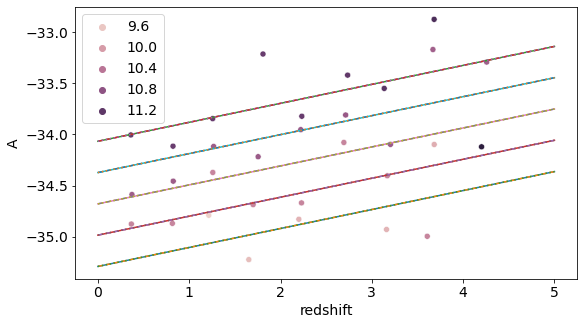

In [46]:
fig, ax = plt.subplots(1,1, figsize=(9,5))
sns.set_color_codes(palette='pastel')
fig=sns.scatterplot(Zs_sf[idx_keep_sf],As_sf[idx_keep_sf], hue=Ms_sf[idx_keep_sf])
#fig.set(ylim=(-38,-32))
fig.set(ylabel='A')
fig.set(xlabel='redshift');
zs_model=np.linspace(0,5,20)
ms_list=[9.6,10,10.4,10.8,11.2]
as_list=[.1,.5,.9]
as_ls=['-','--',':']
for i, im in enumerate(ms_list):
    ms_model=np.zeros_like(zs_model)+im
    try:
        for j, ja in enumerate(as_list):
            as_model=np.zeros_like(zs_model)+ja
            A_mod_plot = model_A_or_Tdust(vA_just_sf, np.array([zs_model.tolist(),ms_model.tolist(),as_model.tolist()]))
            plt.plot(zs_model, A_mod_plot, as_ls[j])
    except:
        A_mod_plot = model_A_or_Tdust(vA_just_sf, np.array([zs_model.tolist(),ms_model.tolist()]))
        plt.plot(zs_model, A_mod_plot)

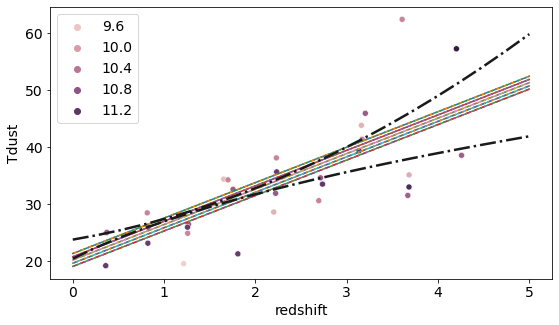

In [47]:
fig, ax = plt.subplots(1,1, figsize=(9,5))
sns.set_color_codes(palette='pastel')
fig=sns.scatterplot(Zs_sf[idx_keep_sf],Ts_sf[idx_keep_sf]-1, hue=Ms_sf[idx_keep_sf])
#fig.set(ylim=(-38,-32))
fig.set(ylabel='Tdust')
fig.set(xlabel='redshift')
zs_model=np.linspace(0,5,20)
ms_list=[9.6,10,10.4,10.8,11.2]
as_list=[.1,.5,.9]
as_ls=['-','--',':']
for i, im in enumerate(ms_list):
    ms_model=np.zeros_like(zs_model)+im
    try:
        for j, ja in enumerate(as_list):
            as_model=np.zeros_like(zs_model)+ja
            T_mod_plot = model_A_or_Tdust(vT_just_sf, np.array([zs_model.tolist(),ms_model.tolist(),as_model.tolist()]))
            plt.plot(zs_model, T_mod_plot, as_ls[j])
    except:
        T_mod_plot = model_A_or_Tdust(vT_just_sf, np.array([zs_model.tolist(),ms_model.tolist()]))
        plt.plot(zs_model, T_mod_plot)
        
plt.plot(zs_model, 27*((1+zs_model)/(1+1))**(0.4), '-.k', lw=2.5, label='Viero 2013');
Tv22 = 23.8 + 2.7 * zs_model + 0.9 * zs_model**2
plt.plot(zs_model, Tv22, '--k', lw=2.5, label='Viero 2022');
plt.legend();

In [48]:
combined_theta_model_just_sf= A_combined_model_just_sf, np.array(T_combined_model_just_sf / (1+Z_model_sf))

# Now fit SF and QT simultaneously

In [49]:
# Define Fit Parameters
fit_params_sfg = Parameters()
fit_params_sfg.add('A_offset_sf', value=vA_just_sf['A_offset'].value)
fit_params_sfg.add('T_offset_sf', value=vT_just_sf['T_offset'].value)
fit_params_sfg.add('A_offset_qt', value=vA_just_qt['A_offset'].value)
fit_params_sfg.add('T_offset_qt', value=vT_just_qt['T_offset'].value)

for key, val in simstack_object.config_dict['catalog']['classification'].items():

    if 'split_params' not in key:
        fit_params_sfg.add('A_slope_'+key+'_sf', value=vA_just_sf['A_slope_'+key].value)
        fit_params_sfg.add('T_slope_'+key+'_sf', value=vT_just_sf['T_slope_'+key].value)
        fit_params_sfg.add('A_slope_'+key+'_qt', value=vA_just_qt['A_slope_'+key].value)
        fit_params_sfg.add('T_slope_'+key+'_qt', value=vT_just_qt['T_slope_'+key].value)
    
cov_direct_fit = minimize(direct_convolved_fit_A_Tdust_two_pop, fit_params_sfg,
                     args=(model_cube,),
                     kws={'y':map_dict},
                     nan_policy='propagate')

In [116]:
# Define Fit Parameters
fit_params_sfg = Parameters()
fit_params_sfg.add('A_offset_sf', value=vA_just_sf['A_offset'].value)
fit_params_sfg.add('T_offset_sf', value=vT_just_sf['T_offset'].value)
fit_params_sfg.add('A_offset_qt', value=vA_just_qt['A_offset'].value)
fit_params_sfg.add('T_offset_qt', value=vT_just_qt['T_offset'].value)

for key, val in simstack_object.config_dict['catalog']['classification'].items():
    print(key)
    if 'split_params' not in key:
        if key == 'redshift':
            vT_init = 4.6
            vary=False
            print('yes')
        else:
            vT_init = vT_just_sf['T_slope_'+key].value
            vary=True
            print('no')
                      
        fit_params_sfg.add('A_slope_'+key+'_sf', value=vA_just_sf['A_slope_'+key].value)
        fit_params_sfg.add('T_slope_'+key+'_sf', value=vT_init, vary=vary)
        fit_params_sfg.add('A_slope_'+key+'_qt', value=vA_just_qt['A_slope_'+key].value)
        fit_params_sfg.add('T_slope_'+key+'_qt', value=vT_just_qt['T_slope_'+key].value)
    
cov_direct_fit_fixed_T = minimize(direct_convolved_fit_A_Tdust_two_pop, fit_params_sfg,
                     args=(model_cube,),
                     kws={'y':map_dict},
                     nan_policy='propagate')

redshift
yes
stellar_mass
no
split_params


In [117]:
cov_direct_fit_fixed_T.params

name,value,standard error,relative error,initial value,min,max,vary
A_offset_sf,-42.3956413,0.03315965,(0.08%),-42.628938662252914,-inf,inf,True
T_offset_sf,29.9149286,0.42303016,(1.41%),34.925998345967166,-inf,inf,True
A_offset_qt,-38.1099578,0.53616630,(1.41%),-43.37305528322381,-inf,inf,True
T_offset_qt,-7.02489701,6.13752123,(87.37%),62.29197412702565,-inf,inf,True
A_slope_redshift_sf,0.27576091,8.4819e-04,(0.31%),0.18536487756599668,-inf,inf,True
T_slope_redshift_sf,4.60000000,0.00000000,(0.00%),4.6,-inf,inf,False
A_slope_redshift_qt,0.22178074,0.01718424,(7.75%),0.07481660025317191,-inf,inf,True
T_slope_redshift_qt,10.4797585,0.27103740,(2.59%),10.120839019274793,-inf,inf,True
A_slope_stellar_mass_sf,0.73326488,0.00315252,(0.43%),0.764386776070724,-inf,inf,True
T_slope_stellar_mass_sf,-0.79399736,0.03993032,(5.03%),-1.4131214252335975,-inf,inf,True


In [50]:
cov_direct_fit_sf.params

name,value,standard error,relative error,initial value,min,max,vary
A_offset,-42.6289387,0.04802523,(0.11%),-42.643180444665475,-inf,inf,True
T_offset,34.9259983,0.63558976,(1.82%),26.84135324433336,-inf,inf,True
A_slope_redshift,0.18536488,0.00278403,(1.50%),0.1681421760649535,-inf,inf,True
T_slope_redshift,6.21289735,0.04467082,(0.72%),6.296034118362334,-inf,inf,True
A_slope_stellar_mass,0.76438678,0.00462817,(0.61%),0.7663627026316421,-inf,inf,True
T_slope_stellar_mass,-1.41312143,0.06071639,(4.30%),-0.6200345379170393,-inf,inf,True


In [53]:
cov_direct_fit.params

name,value,standard error,relative error,initial value,min,max,vary
A_offset_sf,-42.7189484,0.03982343,(0.09%),-42.628938662252914,-inf,inf,True
T_offset_sf,33.5981457,0.52676962,(1.57%),34.925998345967166,-inf,inf,True
A_offset_qt,-38.5850817,0.48030473,(1.24%),-43.37305528322381,-inf,inf,True
T_offset_qt,0.39014828,4.91862781,(1260.71%),62.29197412702565,-inf,inf,True
A_slope_redshift_sf,0.18394984,0.00238592,(1.30%),0.18536487756599668,-inf,inf,True
T_slope_redshift_sf,6.21635898,0.03915515,(0.63%),6.2128973455818155,-inf,inf,True
A_slope_redshift_qt,0.07104605,0.01709566,(24.06%),0.07481660025317191,-inf,inf,True
T_slope_redshift_qt,11.5606079,0.26849835,(2.32%),10.120839019274793,-inf,inf,True
A_slope_stellar_mass_sf,0.77305721,0.00383708,(0.50%),0.764386776070724,-inf,inf,True
T_slope_stellar_mass_sf,-1.28982563,0.05041746,(3.91%),-1.4131214252335975,-inf,inf,True


In [54]:
vT_sf = cov_direct_fit.params.copy()
vA_sf = cov_direct_fit.params.copy()
vT_qt = cov_direct_fit.params.copy()
vA_qt = cov_direct_fit.params.copy()

Alist_sf = [i for i, j in vA_sf.items() if (('A_' in i) or ('_qt' in i))]
Tlist_sf = [i for i, j in vT_sf.items() if (('T_' in i) or ('_qt' in i))]
Apop=[vA_sf.pop(i) for i in Tlist_sf]
Tpop=[vT_sf.pop(i) for i in Alist_sf]

Alist_qt = [i for i, j in vA_qt.items() if (('A_' in i) or ('_sf' in i))]
Tlist_qt = [i for i, j in vT_qt.items() if (('T_' in i) or ('_sf' in i))]
Apop=[vA_qt.pop(i) for i in Tlist_qt]
Tpop=[vT_qt.pop(i) for i in Alist_qt]

In [118]:
vT_sf_fixed = cov_direct_fit_fixed_T.params.copy()
vA_sf_fixed = cov_direct_fit_fixed_T.params.copy()
vT_qt_fixed = cov_direct_fit_fixed_T.params.copy()
vA_qt_fixed = cov_direct_fit_fixed_T.params.copy()

Alist_sf = [i for i, j in vA_sf_fixed.items() if (('A_' in i) or ('_qt' in i))]
Tlist_sf = [i for i, j in vT_sf_fixed.items() if (('T_' in i) or ('_qt' in i))]
Apop=[vA_sf_fixed.pop(i) for i in Tlist_sf]
Tpop=[vT_sf_fixed.pop(i) for i in Alist_sf]

Alist_qt = [i for i, j in vA_qt_fixed.items() if (('A_' in i) or ('_sf' in i))]
Tlist_qt = [i for i, j in vT_qt_fixed.items() if (('T_' in i) or ('_sf' in i))]
Apop=[vA_qt_fixed.pop(i) for i in Tlist_qt]
Tpop=[vT_qt_fixed.pop(i) for i in Alist_qt]

In [55]:
vA_sf

name,value,standard error,relative error,initial value,min,max,vary
A_offset_sf,-42.7189484,0.03982343,(0.09%),-42.628938662252914,-inf,inf,True
A_slope_redshift_sf,0.18394984,0.00238592,(1.30%),0.18536487756599668,-inf,inf,True
A_slope_stellar_mass_sf,0.77305721,0.00383708,(0.50%),0.764386776070724,-inf,inf,True


In [56]:
A_combined_model_sf = model_A_or_Tdust(vA_sf, model_cube_sf)
T_combined_model_sf = model_A_or_Tdust(vT_sf, model_cube_sf)

A_combined_model_qt = model_A_or_Tdust(vA_qt, model_cube_qt)
T_combined_model_qt = model_A_or_Tdust(vT_qt, model_cube_qt)

In [144]:
A_combined_model_sf_fixed = model_A_or_Tdust(vA_sf_fixed, model_cube_sf)
T_combined_model_sf_fixed = model_A_or_Tdust(vT_sf_fixed, model_cube_sf)

A_combined_model_qt_fixed = model_A_or_Tdust(vA_qt_fixed, model_cube_qt)
T_combined_model_qt_fixed = model_A_or_Tdust(vT_qt_fixed, model_cube_qt)

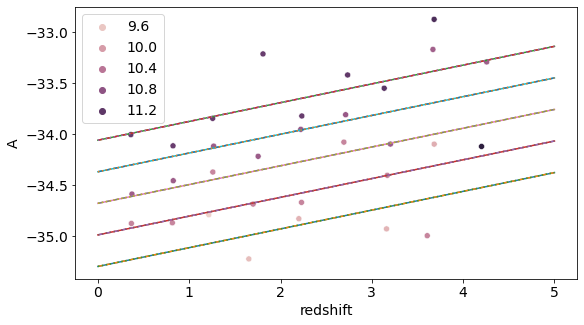

In [57]:
fig, ax = plt.subplots(1,1, figsize=(9,5))
sns.set_color_codes(palette='pastel')
fig=sns.scatterplot(Zs_sf[idx_keep_sf],As_sf[idx_keep_sf], hue=Ms_sf[idx_keep_sf])
#fig.set(ylim=(-38,-32))
fig.set(ylabel='A')
fig.set(xlabel='redshift');
zs_model=np.linspace(0,5,20)
ms_list=[9.6,10,10.4,10.8,11.2]
as_list=[.1,.5,.9]
as_ls=['-','--',':']
for i, im in enumerate(ms_list):
    ms_model=np.zeros_like(zs_model)+im
    try:
        for j, ja in enumerate(as_list):
            as_model=np.zeros_like(zs_model)+ja
            A_mod_plot = model_A_or_Tdust(vA_sf, np.array([zs_model.tolist(),ms_model.tolist(),as_model.tolist()]))
            plt.plot(zs_model, A_mod_plot, as_ls[j])
    except:
        A_mod_plot = model_A_or_Tdust(vA_sf, np.array([zs_model.tolist(),ms_model.tolist()]))
        plt.plot(zs_model, A_mod_plot)

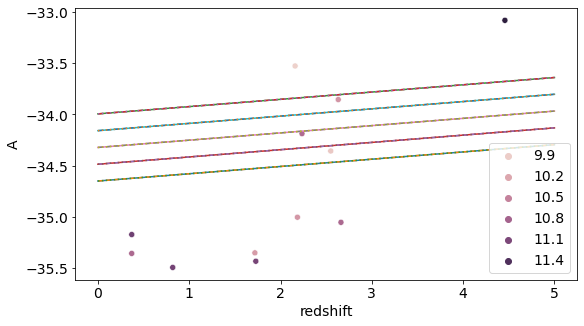

In [58]:
fig, ax = plt.subplots(1,1, figsize=(9,5))
sns.set_color_codes(palette='pastel')
fig=sns.scatterplot(Zs_qt[idx_keep_qt],As_qt[idx_keep_qt], hue=Ms_qt[idx_keep_qt])
#fig.set(ylim=(-38,-32))
fig.set(ylabel='A')
fig.set(xlabel='redshift');
zs_model=np.linspace(0,5,20)
ms_list=[9.6,10,10.4,10.8,11.2]
as_list=[.1,.5,.9]
as_ls=['-','--',':']
for i, im in enumerate(ms_list):
    ms_model=np.zeros_like(zs_model)+im
    try:
        for j, ja in enumerate(as_list):
            as_model=np.zeros_like(zs_model)+ja
            A_mod_plot = model_A_or_Tdust(vA_qt, np.array([zs_model.tolist(),ms_model.tolist(),as_model.tolist()]))
            plt.plot(zs_model, A_mod_plot, as_ls[j])
    except:
        A_mod_plot = model_A_or_Tdust(vA_qt, np.array([zs_model.tolist(),ms_model.tolist()]))
        plt.plot(zs_model, A_mod_plot)

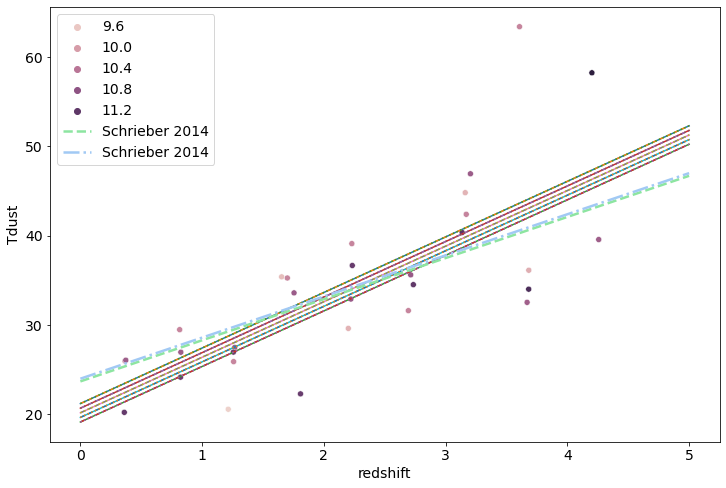

In [106]:
fig, ax = plt.subplots(1,1, figsize=(12,8))
sns.set_color_codes(palette='pastel')
fig=sns.scatterplot(Zs_sf[idx_keep_sf],Ts_sf[idx_keep_sf], hue=Ms_sf[idx_keep_sf])
#fig.set(ylim=(-38,-32))
fig.set(ylabel='Tdust')
fig.set(xlabel='redshift')
zs_model=np.linspace(0,5,20)
ms_list=[9.6,10,10.4,10.8,11.2]
as_list=[.1,.5,.9]
as_ls=['-','--',':']
for i, im in enumerate(ms_list):
    ms_model=np.zeros_like(zs_model)+im
    try:
        for j, ja in enumerate(as_list):
            as_model=np.zeros_like(zs_model)+ja
            T_mod_plot = model_A_or_Tdust(vT_sf, np.array([zs_model.tolist(),ms_model.tolist(),as_model.tolist()]))
            plt.plot(zs_model, T_mod_plot, as_ls[j])
    except:
        T_mod_plot = model_A_or_Tdust(vT_sf, np.array([zs_model.tolist(),ms_model.tolist()]))
        plt.plot(zs_model, T_mod_plot)
        
#plt.plot(zs_model, 27*((1+zs_model)/(1+1))**(0.4), '-.k', lw=2.5, label='Viero 2013');
Tv22 = 23.8 + 2.7 * zs_model + 0.9 * zs_model**2
#plt.plot(zs_model, Tv22, '--k', lw=2.5, label='Viero 2022');

S180 = 32.9 + 4.60* (zs_model- 2)
plt.plot(zs_model, S180, '--g', lw=2.5, label='Schrieber 2014');

S18 = 24 + 4.6 * zs_model
plt.plot(zs_model, S18, '-.b', lw=2.5, label='Schrieber 2014');

plt.legend();

In [77]:
vT_sf

name,value,standard error,relative error,initial value,min,max,vary
T_offset_sf,33.5981457,0.52676962,(1.57%),34.925998345967166,-inf,inf,True
T_slope_redshift_sf,6.21635898,0.03915515,(0.63%),6.2128973455818155,-inf,inf,True
T_slope_stellar_mass_sf,-1.28982563,0.05041746,(3.91%),-1.4131214252335975,-inf,inf,True


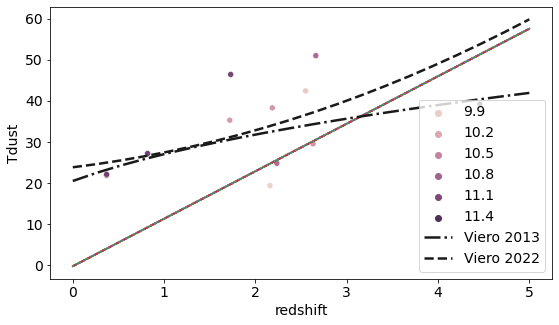

In [60]:
fig, ax = plt.subplots(1,1, figsize=(9,5))
sns.set_color_codes(palette='pastel')
fig=sns.scatterplot(Zs_qt[idx_keep_qt],Ts_qt[idx_keep_qt]-1, hue=Ms_qt[idx_keep_qt])
#fig.set(ylim=(-38,-32))
fig.set(ylabel='Tdust')
fig.set(xlabel='redshift')
zs_model=np.linspace(0,5,20)
ms_list=[9.6,10,10.4,10.8,11.2]
as_list=[.1,.5,.9]
as_ls=['-','--',':']
for i, im in enumerate(ms_list):
    ms_model=np.zeros_like(zs_model)+im
    try:
        for j, ja in enumerate(as_list):
            as_model=np.zeros_like(zs_model)+ja
            T_mod_plot = model_A_or_Tdust(vT_qt, np.array([zs_model.tolist(),ms_model.tolist(),as_model.tolist()]))
            plt.plot(zs_model, T_mod_plot, as_ls[j])
    except:
        T_mod_plot = model_A_or_Tdust(vT_qt, np.array([zs_model.tolist(),ms_model.tolist()]))
        plt.plot(zs_model, T_mod_plot)
        
plt.plot(zs_model, 27*((1+zs_model)/(1+1))**(0.4), '-.k', lw=2.5, label='Viero 2013');
Tv22 = 23.8 + 2.7 * zs_model + 0.9 * zs_model**2
plt.plot(zs_model, Tv22, '--k', lw=2.5, label='Viero 2022');
plt.legend();

# Decompose LIR into AGN and non-AGN

In [61]:
L_sun = 3.839e26  # W
c = 299792458.0  # m/s
def fast_LIR(self, theta, zed, dzin=None):
    '''This calls graybody_fn instead of fast_sed'''
    wavelength_range = self.loggen(8, 1000, 1000)
    Lrf_array = np.zeros_like(zed)
    for iz, zin in enumerate(zed):
        theta_in = theta[0][iz], theta[1][iz]
        model_sed = self.graybody_fn(theta_in, wavelength_range)

        nu_in = c * 1.e6 / wavelength_range
        dnu = nu_in[:-1] - nu_in[1:]
        dnu = np.append(dnu[0], dnu)
        Lir = np.sum(model_sed * dnu, axis=1)
        conversion = 4.0 * np.pi * (
                    1.0E-13 * self.config_dict['cosmology_dict']['cosmology'].luminosity_distance(
                zin) * 3.08568025E22) ** 2.0 / L_sun  # 4 * pi * D_L^2    units are L_sun/(Jy x Hz)

        Lrf = (Lir * conversion.value)[0]  # Jy x Hz

        if dzin is not None:
            dLrf = np.zeros([2])
            for idz, dz in enumerate(dzin):
                conversion = 4.0 * np.pi * (
                        1.0E-13 * self.config_dict['cosmology_dict']['cosmology'].luminosity_distance(
                    dz) * 3.08568025E22) ** 2.0 / L_sun  # 4 * pi * D_L^2    units are L_sun/(Jy x Hz)
                dLrf[idz] = (Lir * conversion.value)[0]

            #return Lrf, dLrf
            Lrf_array[iz] = Lrf, dLrf
            
        Lrf_array[iz] = Lrf

    return Lrf_array

In [64]:
combined_theta_model_sf = A_combined_model_sf, np.array(T_combined_model_sf / (1+Z_model_sf))
combined_theta_model_qt = A_combined_model_qt, np.array(T_combined_model_qt / (1+Z_model_qt))

In [145]:
combined_theta_model_sf_fixed = A_combined_model_sf_fixed, np.array(T_combined_model_sf_fixed / (1+Z_model_sf))
combined_theta_model_qt_fixed = A_combined_model_qt_fixed, np.array(T_combined_model_qt_fixed / (1+Z_model_qt))

In [65]:
LIR_model_just_sf = fast_LIR(simstack_object, combined_theta_model_just_sf, Z_model_sf)

In [66]:
LIR_model_sf = fast_LIR(simstack_object, combined_theta_model_sf, Z_model_sf)

In [146]:
LIR_model_sf_fixed = fast_LIR(simstack_object, combined_theta_model_sf_fixed, Z_model_sf)

In [67]:
LIR_model_qt = fast_LIR(simstack_object, combined_theta_model_qt, Z_model_qt)

In [147]:
LIR_model_qt_fixed = fast_LIR(simstack_object, combined_theta_model_qt_fixed, Z_model_qt)

In [68]:
idx_sample_sf = np.random.choice(np.arange(len(Z_model_sf)), size=10000, replace=False)

In [69]:
idx_sample_qt = np.random.choice(np.arange(len(Z_model_qt)), size=10000, replace=False)

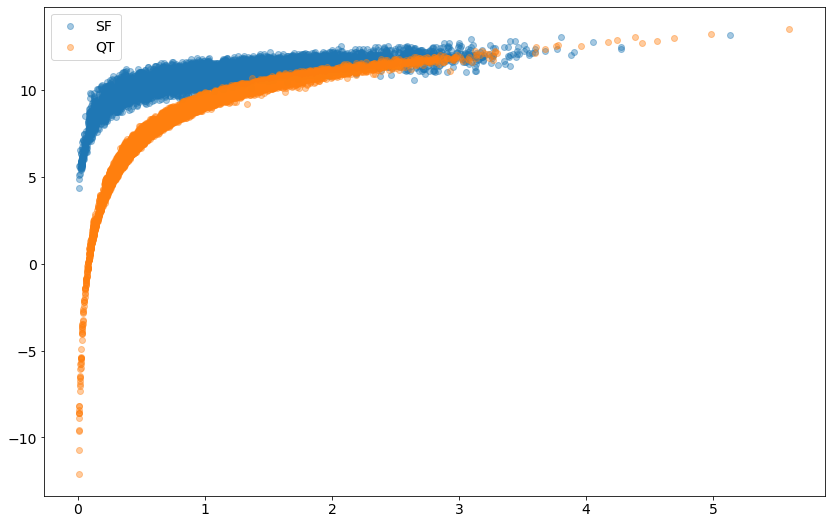

In [70]:
fig, axs = plt.subplots(1, 1, figsize=(14,9))
plt.scatter(Z_model_sf.iloc[idx_sample_sf], np.log10(LIR_model_sf[idx_sample_sf]), alpha=0.4, label='SF');
plt.scatter(Z_model_qt.iloc[idx_sample_qt], np.log10(LIR_model_qt[idx_sample_qt]), alpha=0.4, label='QT');
plt.legend();

In [148]:
zbins = np.array([0, .25, .5, 1, 1.5, 2, 2.5, 3, 4, 5])
binned_z = (zbins[:-1]+zbins[1:])/2

binned_lir_just_sf = np.zeros(len(zbins)-1)

binned_lir_sf_fixed = np.zeros(len(zbins)-1)
binned_lir_qt_fixed = np.zeros(len(zbins)-1)
binned_lir_sf = np.zeros(len(zbins)-1)
binned_lir_qt = np.zeros(len(zbins)-1)

binned_uv_sfr_sf = np.zeros(len(zbins)-1)
binned_uv_sfr_qt = np.zeros(len(zbins)-1)
binned_uv_sfr = np.zeros(len(zbins)-1)

binned_vol = np.zeros(len(zbins)-1)
area_deg2 = 1.8 #1.6055

for iz in np.arange(len(zbins)-1):
    idx_z_sf = (Z_model_sf > zbins[iz]) & (Z_model_sf <= zbins[iz+1])
    idx_z_qt = (Z_model_qt > zbins[iz]) & (Z_model_qt <= zbins[iz+1])
    
    binned_lir_just_sf[iz] = np.sum(LIR_model_just_sf[idx_z_sf],axis=0)
    
    binned_lir_sf_fixed[iz] = np.sum(LIR_model_sf_fixed[idx_z_sf],axis=0)
    binned_lir_qt_fixed[iz] = np.sum(LIR_model_qt_fixed[idx_z_qt],axis=0)
    binned_lir_sf[iz] = np.sum(LIR_model_sf[idx_z_sf],axis=0)
    binned_lir_qt[iz] = np.sum(LIR_model_qt[idx_z_qt],axis=0)
    
    binned_uv_sfr_sf[iz] = np.sum(uv_sfr_sf[idx_z_sf])
    binned_uv_sfr_qt[iz] = np.sum(uv_sfr_qt[idx_z_qt])
    
    idx_z_whole = (simstack_catalog_object.catalog_dict['tables']['full_table']['z_peak'] > zbins[iz]) & (simstack_catalog_object.catalog_dict['tables']['full_table']['z_peak'] <= zbins[iz+1])
    binned_uv_sfr[iz] = np.sum(simstack_catalog_object.catalog_dict['tables']['full_table']['SFR_UV'][idx_z_whole])
    
    binned_vol[iz] = simstack_object.comoving_volume_given_area(area_deg2, zbins[iz], zbins[iz+1]).value

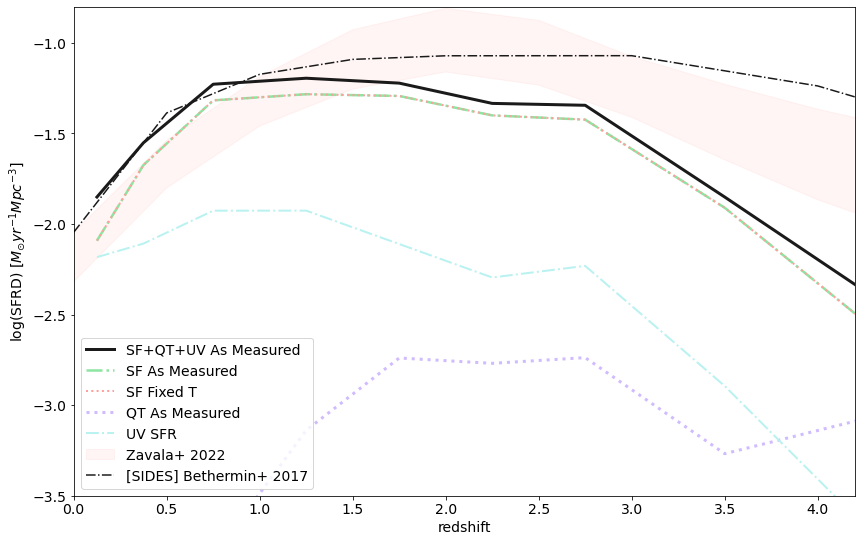

In [149]:
conv_lir_to_sfr = 1.728e-10  / 10 ** 0.23
fig, axs = plt.subplots(1, 1, figsize=(14,9))

plt.plot(binned_z, np.log10((conv_lir_to_sfr*(binned_lir_sf+binned_lir_qt)+binned_uv_sfr_sf)/binned_vol), 'k', lw=3, label='SF+QT+UV As Measured')

plt.plot(binned_z, np.log10((conv_lir_to_sfr*(binned_lir_sf))/binned_vol), '-.g', lw=2.5, label='SF As Measured')
plt.plot(binned_z, np.log10((conv_lir_to_sfr*(binned_lir_sf))/binned_vol), ':r', lw=2, label='SF Fixed T')
plt.plot(binned_z, np.log10((conv_lir_to_sfr*(binned_lir_qt))/binned_vol), ':m', lw=3, label='QT As Measured')

plt.plot(binned_z, np.log10(binned_uv_sfr /binned_vol), '-.c', lw=2,  label='UV SFR')

xzav = [0, 0.5, 1, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0]
yzav0 = [0.009, 0.029, 0.065, 0.118, 0.155, 0.133, 0.084, 0.059, 0.043, 0.033, 0.026, 0.02, 0.016, 0.014,
         0.012]
yzav1 = [0.0048, 0.0158, 0.0347, 0.0555, 0.069, 0.0584, 0.0388, 0.0226, 0.0136, 0.009, 0.005, 0.004, 0.0039,
         0.0032, 0.0026]
plt.fill_between(xzav, np.log10(yzav0), np.log10(yzav1), facecolor='r', alpha=0.1, edgecolor='r',
                 label='Zavala+ 2022')

xsides = [0, 0.5, 1, 1.5, 2.0, 3.0, 4.0, 5.0, 6.0, 6.5, 7.0]
ysides = [0.009, 0.041, 0.067, 0.081, 0.0848, 0.0849, 0.0578, 0.0288, 0.0168, 0.0093, 0.0058]
plt.plot(xsides, np.log10(ysides), '-.', c='k', lw=1.5, label='[SIDES] Bethermin+ 2017')

xill = [0, 0.5, 1, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0]
yill = [0.0117, 0.0253, 0.0431, 0.0562, 0.0674, 0.0666, 0.0651, 0.0531, 0.0500, 0.0455, 0.0295, 0.0193,
        0.0156, 0.0114, 0.008]
#plt.plot(xill, np.log10(yill), '--', c='g', lw=2, label='[IllustrisTNG] Pillepich+ 2018')

plt.xlabel('redshift')
#plt.ylabel('LIRD');
plt.ylabel('log(SFRD) [$M_{\odot} yr^{-1} Mpc^{-3}$]');
plt.xlim([0,4.2])
#plt.ylim([7,9]);
plt.ylim([-3.5,-0.8]);
#plt.ylim(np.l#og10([4e-3,5e-1]));
plt.legend();

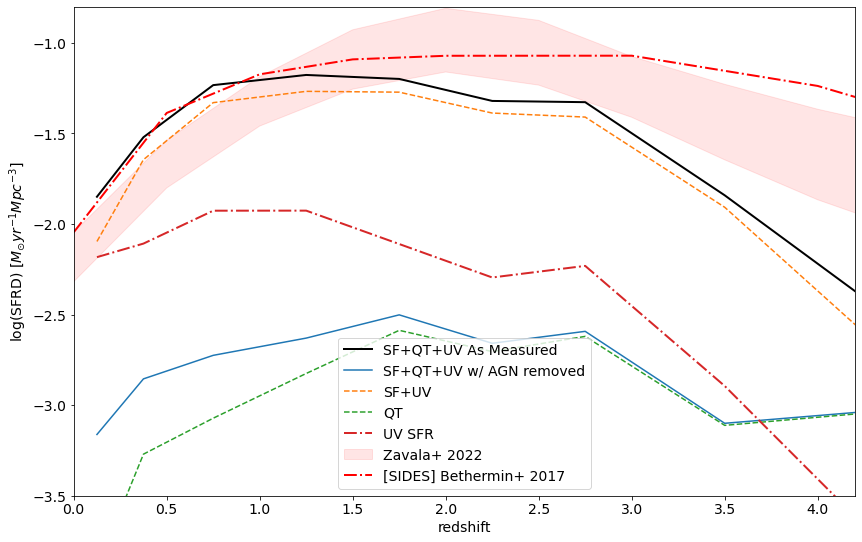

In [58]:
conv_lir_to_sfr = 1.728e-10  / 10 ** 0.23
fig, axs = plt.subplots(1, 1, figsize=(14,9))

plt.plot(binned_z, np.log10((conv_lir_to_sfr*(binned_lir_sf_agn+binned_lir_qt_agn)+binned_uv_sfr_sf)/binned_vol), 'k', lw=2, label='SF+QT+UV As Measured')
plt.plot(binned_z, np.log10((conv_lir_to_sfr*(binned_lir_sf+binned_lir_qt_agn)+binned_uv_sfr_qt)/binned_vol), label='SF+QT+UV w/ AGN removed')

plt.plot(binned_z, np.log10((conv_lir_to_sfr*(binned_lir_sf_agn+binned_uv_sfr_sf))/binned_vol), '--', label='SF+UV')
plt.plot(binned_z, np.log10((conv_lir_to_sfr*(binned_lir_qt_agn))/binned_vol), '--', label='QT')

plt.plot(binned_z, np.log10(binned_uv_sfr /binned_vol), '-.', lw=2,  label='UV SFR')

xzav = [0, 0.5, 1, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0]
yzav0 = [0.009, 0.029, 0.065, 0.118, 0.155, 0.133, 0.084, 0.059, 0.043, 0.033, 0.026, 0.02, 0.016, 0.014,
         0.012]
yzav1 = [0.0048, 0.0158, 0.0347, 0.0555, 0.069, 0.0584, 0.0388, 0.0226, 0.0136, 0.009, 0.005, 0.004, 0.0039,
         0.0032, 0.0026]
plt.fill_between(xzav, np.log10(yzav0), np.log10(yzav1), facecolor='r', alpha=0.1, edgecolor='r',
                 label='Zavala+ 2022')

xsides = [0, 0.5, 1, 1.5, 2.0, 3.0, 4.0, 5.0, 6.0, 6.5, 7.0]
ysides = [0.009, 0.041, 0.067, 0.081, 0.0848, 0.0849, 0.0578, 0.0288, 0.0168, 0.0093, 0.0058]
plt.plot(xsides, np.log10(ysides), '-.', c='r', lw=2, label='[SIDES] Bethermin+ 2017')

xill = [0, 0.5, 1, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0]
yill = [0.0117, 0.0253, 0.0431, 0.0562, 0.0674, 0.0666, 0.0651, 0.0531, 0.0500, 0.0455, 0.0295, 0.0193,
        0.0156, 0.0114, 0.008]
#plt.plot(xill, np.log10(yill), '--', c='g', lw=2, label='[IllustrisTNG] Pillepich+ 2018')

plt.xlabel('redshift')
#plt.ylabel('LIRD');
plt.ylabel('log(SFRD) [$M_{\odot} yr^{-1} Mpc^{-3}$]');
plt.xlim([0,4.2])
#plt.ylim([7,9]);
plt.ylim([-3.5,-0.8]);
#plt.ylim(np.l#og10([4e-3,5e-1]));
plt.legend();

## Now make maps from fits

In [131]:
simmap_dict = {}
for map_key in simstack_maps_object.maps_dict:
    map_object = simstack_maps_object.maps_dict[map_key]
    map_lambda = map_object['wavelength']
    map_nu = c * 1.e6/map_lambda
    x, y = get_x_y_from_ra_dec(map_object, ra_model_sf, dec_model_sf)
    simmap_dict[map_key] = np.zeros_like(map_object['map'])
    simmap_dict[map_key][x,y] += get_map_flux_mJy(np.array([map_nu]),A_combined_model_sf,T_combined_model_sf/np.array(1+Z_model_sf))
    
    x, y = get_x_y_from_ra_dec(map_object, ra_model_qt, dec_model_qt)
    simmap_dict[map_key][x,y] += get_map_flux_mJy(np.array([map_nu]),A_combined_model_qt,T_combined_model_qt/np.array(1+Z_model_qt))

In [151]:
simmap_dict = {}
for map_key in simstack_maps_object.maps_dict:
    map_object = simstack_maps_object.maps_dict[map_key]
    map_lambda = map_object['wavelength']
    map_nu = c * 1.e6/map_lambda
    x, y = get_x_y_from_ra_dec(map_object, ra_model_sf, dec_model_sf)
    simmap_dict[map_key] = np.zeros_like(map_object['map'])
    simmap_dict[map_key][x,y] += get_map_flux_mJy(np.array([map_nu]),A_combined_model_sf_fixed,T_combined_model_sf_fixed/np.array(1+Z_model_sf))
    
    x, y = get_x_y_from_ra_dec(map_object, ra_model_qt, dec_model_qt)
    simmap_dict[map_key][x,y] += get_map_flux_mJy(np.array([map_nu]),A_combined_model_qt_fixed,T_combined_model_qt_fixed/np.array(1+Z_model_qt))

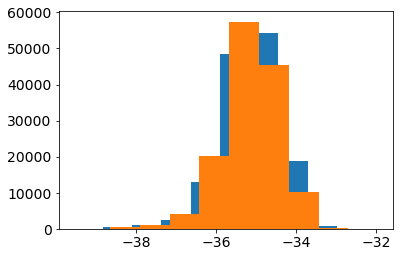

In [153]:
plt.hist(A_combined_model_sf);
plt.hist(A_combined_model_sf_fixed);

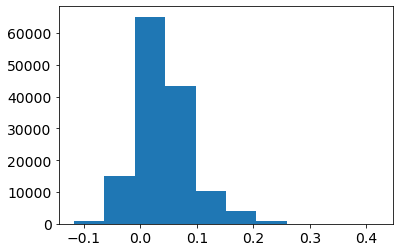

In [155]:
plt.hist(A_combined_model_sf_fixed-A_combined_model_sf);

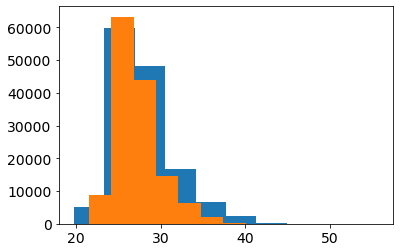

In [154]:
plt.hist(T_combined_model_sf);
plt.hist(T_combined_model_sf_fixed);

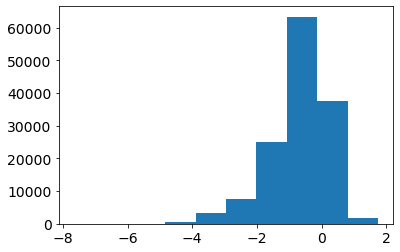

In [156]:
plt.hist(T_combined_model_sf_fixed-T_combined_model_sf);

In [140]:
outmap_dict={}
def write_fits(self,
               mapin,
               map_name,
               path_map=r'C:\Users\viero\Desktop', 
               prefix='model_',
               overwrite=True, 
               show=False):
    
    if show:
        plt.imshow(model_250)

    map_object = self.maps_dict[map_name]
    #path_map = r'D:\maps\cutouts\layers'
    name_map = prefix+str(map_name)+'.fits'

    hd = map_object['header']
    fwhm = map_object['fwhm']
    pix = map_object['pixel_size']
    kern = gauss_kern(fwhm, np.floor(fwhm * 10) / pix, pix)
    tmap = smooth_psf(mapin, kern)
    
    ind_zero = abs(tmap) < 1e-10
    ind_non_zero = mapin != 0
    smap = tmap
    smap -= np.mean(smap[ind_non_zero])
    #smap[ind_zero]=0

    hdu = fits.PrimaryHDU(smap, header=hd)
    hdul = fits.HDUList([hdu])
    hdul.writeto(os.path.join(path_map, name_map),overwrite=overwrite)
    outmap_dict[name_map]=smap
    print('{0} written to {1}'.format(name_map,path_map))

In [152]:
for map_key in simmap_dict:
    #write_fits(simstack_maps_object, simmap_dict[map_key], map_key, prefix='mapfit_'+prefix)    
    write_fits(simstack_maps_object, simmap_dict[map_key], map_key, prefix='sfg_and_qt2_convolved_mapfit_fixed_z_Trf'+prefix)

sfg_and_qt2_convolved_mapfit_fixed_z_TrfSF_QT__A gt_n35p5_mips_24.fits written to C:\Users\viero\Desktop
sfg_and_qt2_convolved_mapfit_fixed_z_TrfSF_QT__A gt_n35p5_pacs_green.fits written to C:\Users\viero\Desktop
sfg_and_qt2_convolved_mapfit_fixed_z_TrfSF_QT__A gt_n35p5_pacs_red.fits written to C:\Users\viero\Desktop
sfg_and_qt2_convolved_mapfit_fixed_z_TrfSF_QT__A gt_n35p5_spire_psw.fits written to C:\Users\viero\Desktop
sfg_and_qt2_convolved_mapfit_fixed_z_TrfSF_QT__A gt_n35p5_spire_pmw.fits written to C:\Users\viero\Desktop
sfg_and_qt2_convolved_mapfit_fixed_z_TrfSF_QT__A gt_n35p5_spire_plw.fits written to C:\Users\viero\Desktop
sfg_and_qt2_convolved_mapfit_fixed_z_TrfSF_QT__A gt_n35p5_scuba_850.fits written to C:\Users\viero\Desktop
